In [1]:
# sciencey preamble
%matplotlib inline
import numpy as np
import seaborn
seaborn.set(rc={"figure.figsize": (15, 6)})

def matshow(mat, **kwargs):
    seaborn.heatmap(mat, square=True, xticklabels=50, yticklabels=50, **kwargs)

In [2]:
from conceptnet_retrofitting.loaders import *
from conceptnet_retrofitting.word_vectors import WordVectors
from conceptnet_retrofitting.builders.build_assoc import build_relations_from_conceptnet
from conceptnet_retrofitting.builders.label_set import LabelSet
from sklearn.preprocessing import normalize

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/scikit_learn-0.16.1-py3.5-linux-x86_64.egg/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [3]:
PATH = '../build-data/'

In [4]:
labels = LabelSet(load_labels(PATH + 'glove.840B.300d.filtered.conceptnet5.labels'))
sparse_rels = build_relations_from_conceptnet(labels, '/wobbly/data/conceptnet5/assoc/reduced.csv')

In [25]:
cnglove = load_word_vectors(PATH + 'glove.840B.300d.filtered.conceptnet5.labels', PATH + 'glove.840B.300d.l1.filtered.conceptnet5.npy', PATH + 'wl1-replacements.msgpack')
glove = load_word_vectors(PATH + 'glove.840B.300d.standardized.labels', PATH + 'glove.840B.300d.l1.standardized.npy')

In [6]:
from conceptnet_retrofitting.builders.retrofit import dense_relation_array

In [7]:
rel_array = dense_relation_array(cnglove.vectors[:100000], {rel: sp[:100000, :100000] for (rel, sp) in sparse_rels.items()})

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


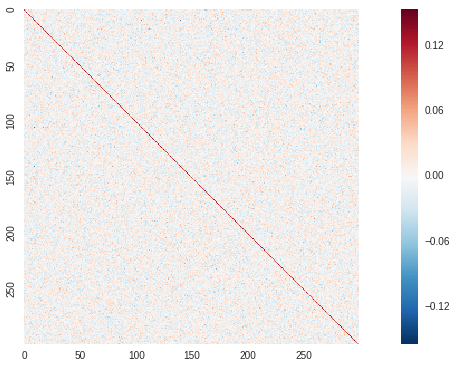

In [8]:
matshow(rel_array[-1])

In [9]:
def en_filter(term):
    return term.startswith('/c/en/')

In [10]:
rel_labels = sorted(sparse_rels)

In [11]:
def read_analogies(filename):
    for line in open(filename, encoding='utf-8'):
        line = line.rstrip()
        if not line or line.startswith('#'):
            continue
        parts = line.split('\t')
        inputs = parts[1:4]
        answers = parts[4:]
        yield inputs, answers

In [12]:
sym_rel_array = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)

In [13]:
any_rel = np.mean(cnglove.vectors, 0) @ sym_rel_array @ np.mean(cnglove.vectors, 0)

In [14]:
def which_relation(wv, rar, c1, c2):
    rels = wv.to_vector(c2) @ rar @ wv.to_vector(c1)
    diff = np.maximum(0, rels - any_rel) ** 2
    diff /= np.sum(diff)
    return diff

In [15]:
def rank3_inner_product(vec, array3):
    return (array3 * vec[:, np.newaxis, np.newaxis]).sum(0)

In [16]:
def eval_analogy(wv, rel_array, c1, c2, c3, c4):
    if c4 in (c1, c2, c3):
        return 0.
    rar = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)
    try:
        relA = which_relation(wv, rar, c1, c2)
        relB = which_relation(wv, rar, c1, c3)
        relAr = rank3_inner_product(relA, rar)
        relBr = rank3_inner_product(relB, rar)
        v1, v2, v3, v4 = [wv.to_vector(c) for c in (c1, c2, c3, c4)]
        numer1 = v4 @ relAr @ v3 + 1
        numer2 = v4 @ relBr @ v2 + 1
        denom1 = v4 @ relAr @ v1 + 1
        denom2 = v4 @ relBr @ v1 + 1
    except KeyError:
        return 0.
    return (numer1 ** 2 * numer2) / (denom1 + denom2)


In [17]:
def analogy(wv, rel_array, c1, c2, c3, num=20):
    rar = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)

    relA = which_relation(wv, rar, c1, c2)
    relB = which_relation(wv, rar, c1, c3)
    print("RelA")
    for label, strength in zip(rel_labels + rel_labels, relA):
        print('\t%-20s\t% 7.1f' % (label, strength * 1000))
    print("RelB")
    for label, strength in zip(rel_labels + rel_labels, relB):
        print('\t%-20s\t% 7.1f' % (label, strength * 1000))
    relAr = rank3_inner_product(relA, rar)
    relBr = rank3_inner_product(relB, rar)
    v1, v2, v3 = [wv.to_vector(c) for c in (c1, c2, c3)]
    numer1 = wv.vectors @ (relAr @ v3) + 1
    numer2 = wv.vectors @ (relBr @ v2) + 1
    denom1 = wv.vectors @ (relAr @ v1) + 1
    denom2 = wv.vectors @ (relBr @ v1) + 1
    ratings = (numer1 ** 2 * numer2) / (denom1 + denom2)
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label):
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found

In [50]:
analogy(cnglove, rel_array, 'Russia', 'Aeroflot', 'Mexico', num=20)

RelA
	/r/Antonym          	   28.2
	/r/AtLocation       	    4.0
	/r/AtLocation/back  	    5.1
	/r/Causes           	    1.5
	/r/Causes/back      	    1.6
	/r/HasProperty      	    2.7
	/r/HasProperty/back 	    1.7
	/r/HasSubevent      	    0.0
	/r/HasSubevent/back 	    0.0
	/r/IsA              	   33.9
	/r/IsA/back         	   14.0
	/r/PartOf           	  179.6
	/r/PartOf/back      	   76.8
	/r/RelatedTo        	  147.2
	/r/UsedFor          	    4.5
	/r/UsedFor/back     	    0.4
	/r/Antonym          	   27.9
	/r/AtLocation       	    4.9
	/r/AtLocation/back  	    3.6
	/r/Causes           	    1.6
	/r/Causes/back      	    0.8
	/r/HasProperty      	    1.5
	/r/HasProperty/back 	    2.2
	/r/HasSubevent      	    0.6
	/r/HasSubevent/back 	    0.0
	/r/IsA              	   12.6
	/r/IsA/back         	   37.6
	/r/PartOf           	   76.6
	/r/PartOf/back      	  178.6
	/r/RelatedTo        	  147.2
	/r/UsedFor          	    0.6
	/r/UsedFor/back     	    2.5
RelB
	/r/Antonym          	   77.5


[('/c/en/mexico', 1.2842383817315537),
 ('/c/en/guadalajara', 1.2337538381846098),
 ('/c/en/puebla', 1.2046599115390852),
 ('/c/en/monterrey', 1.187435363895482),
 ('/c/en/acapulco', 1.1806571734101945),
 ('/c/en/mazatlan', 1.1708530000095783),
 ('/c/en/veracruz', 1.1686888376403959),
 ('/c/en/oaxaca', 1.1651885585715662),
 ('/c/en/jalisco', 1.1580256034222349),
 ('/c/en/tijuana', 1.152191093961406),
 ('/c/en/mexican', 1.0952966562440789),
 ('/c/en/vallarta', 1.0504823114540713),
 ('/c/en/puerto', 1.0499159497416246),
 ('/c/en/chiapas', 1.0498447308161079),
 ('/c/en/nogales', 1.0496070480350443),
 ('/c/en/méxico', 1.049064670168399),
 ('/c/en/yucatan', 1.0392075337994877),
 ('/c/en/laredo', 1.0211534827445539),
 ('/c/en/albuquerque', 1.0205387170387208),
 ('/c/en/toluca', 1.0135832493856023)]

In [19]:
def analogy_3cosmul(wv, c1, c2, c3, num=20):
    sims1 = (wv.vectors @ wv.to_vector(c1)) + 1.000001
    sims2 = (wv.vectors @ wv.to_vector(c2)) + 1
    sims3 = (wv.vectors @ wv.to_vector(c3)) + 1
    ratings = sims2 * sims3 / (sims1)
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label):
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found


In [20]:
def eval_analogy_3cosmul(wv, c1, c2, c3, c4):
    try:
        v4 = wv.to_vector(c4)
        sim1 = v4 @ wv.to_vector(c1) + 1.000001
        sim2 = v4 @ wv.to_vector(c2) + 1
        sim3 = v4 @ wv.to_vector(c3) + 1
    except KeyError:
        return 0.
    return sim2 * (sim3 ** 3) / sim1

In [51]:
def eval_analogies(analogy_func, filename='/nfs/broadway/data/corpora/readtheory-analogies.txt'):
    total = 0
    correct = 0
    for inputs, answers in read_analogies(filename):
        # The 'inputs' are the three given components of the analogy.
        # 'answers' are the multiple-choice answers, where the correct answer is first in the list.
        best_score = 0.
        best_answer = ''
        for answer in answers:
            quad = inputs + [answer]
            score = analogy_func(*quad)
            if score >= best_score:
                best_score = score
                best_answer = answer
        total += 1
        if best_answer == answers[0]:
            correct += 1
        else:
            items = tuple(inputs + [best_answer.upper()] + [answers[0].upper()])
            print("%s : %s :: %s : %s (should be %s)" % items)
    print("Score: %2.2f%% (%d/%d)" % (correct / total * 100, correct, total))
    return correct / total

In [52]:
def curry_3cosmul(c1, c2, c3, c4):
    return eval_analogy_3cosmul(glove, c1, c2, c3, c4)

In [53]:
def curry_inferred(c1, c2, c3, c4):
    return eval_analogy(cnglove, rel_array, c1, c2, c3, c4)

In [54]:
print('\n3cosmul:')
eval_analogies(curry_3cosmul)
print('\ninferred relations:')
eval_analogies(curry_inferred)

print('\n3cosmul:')
eval_analogies(curry_3cosmul, filename='/nfs/broadway/data/corpora/learningexpress-analogies.txt')
print('\ninferred relations:')
eval_analogies(curry_inferred, filename='/nfs/broadway/data/corpora/learningexpress-analogies.txt')


3cosmul:
dirt : brown :: leaves : GRAY (should be GREEN)
shoes : feet :: helmet : ARMS (should be HEAD)
poor : money :: sad : FEELINGS (should be HAPPINESS)
now : later :: easy : SIMPLE (should be DIFFICULT)
lettuce : green :: strawberry : ORANGE (should be RED)
fire : hot :: snow : WARM (should be FROZEN)
spend : save :: give : ASK (should be RECEIVE)
race : competition :: party : DANCE (should be CELEBRATION)
octagon : eight :: triangle : FOUR (should be THREE)
Score: 90.22% (83/92)

inferred relations:
shoes : feet :: helmet : ARMS (should be HEAD)
lettuce : green :: strawberry : ORANGE (should be RED)
Score: 97.83% (90/92)

3cosmul:
train : board :: horse : STABLE (should be MOUNT)
hair : coif :: musical : PRAISE (should be SCORE)
fetish : fixation :: slight : CONFUSE (should be INSULT)
obscene : coarse :: obtuse : OBSCURE (should be STUPID)
diamond : baseball :: court : JURY (should be SQUASH)
smear : libel :: heed : DOUBT (should be CONSIDER)
marshal : prisoner :: principal : TE

0.7407407407407407